**Coronavirus Analysis**

This analysis will be me just playing around with the csv files from 2020-08-11 which contain Time Series data for coronavirus in the UK from https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#time-series-documents. First we load in the data.

In [28]:
import pandas as pd

deaths = pd.read_csv('2020-08-11_COVID-19_UK_deaths_time_series.csv')
positive_cases = pd.read_csv('2020-08-11_COVID-19_UK_positive_cases_time_series_by_specimen_date.csv')
tests = pd.read_csv('2020-08-11_COVID-19_UK_testing_time_series.csv')


Now I want to just clean up the column names of the deaths and cases dataframes so they're easier to work with.

In [29]:
deaths.columns=["date","date_published","cumulative_deaths","daily_deaths"]
positive_cases.columns = ["date","nation","pillar","daily_cases","cumulative_cases"]
deaths.head()

,date,date_published,cumulative_deaths,daily_deaths
0,05/03/2020,06/03/2020,1.0,1.0
1,06/03/2020,07/03/2020,2.0,1.0
2,07/03/2020,08/03/2020,2.0,0.0
3,08/03/2020,09/03/2020,3.0,1.0
4,09/03/2020,10/03/2020,7.0,4.0


In [30]:
positive_cases.head(15)

,date,nation,pillar,daily_cases,cumulative_cases
0,30/01/2020,England,Pillar 1,2,2
1,30/01/2020,Northern Ireland,Pillar 1,0,0
2,30/01/2020,Scotland,Pillar 1,0,0
3,30/01/2020,Wales,Pillar 1,0,0
4,30/01/2020,UK,Pillar 1,2,2
5,30/01/2020,England,Pillar 2,0,0
6,30/01/2020,Northern Ireland,Pillar 2,0,0
7,30/01/2020,Scotland,Pillar 2,0,0
8,30/01/2020,Wales,Pillar 2,0,0
9,30/01/2020,UK,Pillar 2,0,0


To understand what this data looks like we need to plot it. The deaths data is easy to plot because each day has only one entry.

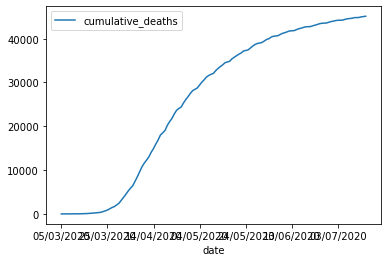

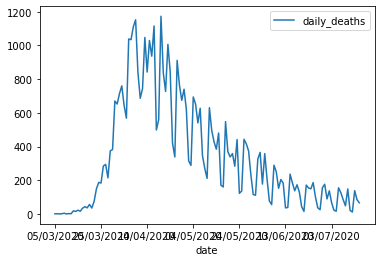

In [31]:
deaths.plot(x='date',y='cumulative_deaths')
deaths.plot(x='date',y='daily_deaths')

However, the positive_cases dataframe is split by Nation and by Pillar (categories of tests). In order to create an easy dataframe to plot we just need to pull out all the entries with the Nation being UK and combine the pillars together. For the sake of simplicity we can drop the Pillar and Nation columns as it is just for the UK in general and all tests.

In [32]:
import numpy as np

UK_cases = positive_cases[positive_cases['nation']=='UK']

daily_cases = UK_cases[UK_cases['pillar'] == 'Pillar 1']['daily_cases'].to_numpy() + UK_cases[UK_cases['pillar'] == 'Pillar 2']['daily_cases'].to_numpy()
cumulative_cases = UK_cases[UK_cases['pillar'] == 'Pillar 1']['cumulative_cases'].to_numpy() + UK_cases[UK_cases['pillar'] == 'Pillar 2']['cumulative_cases'].to_numpy()

UK_cases = pd.DataFrame({'date': UK_cases[UK_cases['pillar'] == 'Pillar 1']['date'], 'daily_cases': daily_cases, 'cumulative_cases': cumulative_cases})
UK_cases.index = range(len(daily_cases))
UK_cases

,date,daily_cases,cumulative_cases
0,30/01/2020,2,2
1,31/01/2020,0,2
2,01/02/2020,0,2
3,02/02/2020,0,2
4,03/02/2020,1,3
...,...,...,...
189,06/08/2020,1027,310775
190,07/08/2020,853,311628
191,08/08/2020,629,312257
192,09/08/2020,439,312696


Now we can plot this new dataframe of UK cases with all types of tests combined.

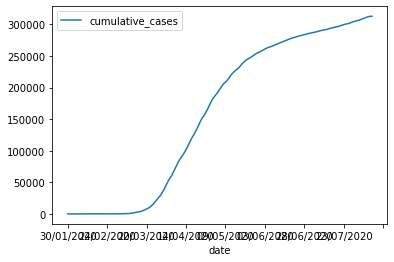

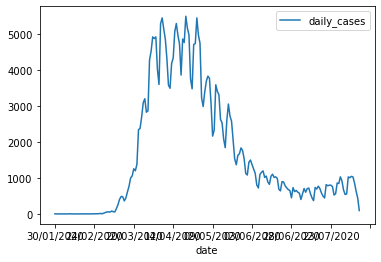

In [34]:
UK_cases.plot(x='date',y='cumulative_cases')
UK_cases.plot(x='date',y='daily_cases')

Although the x-axis of these graphs are hard to read they just represent continuation of time so I am not going to orient the text to make it easier to read. 

From just these graphs we can get a good indication of how the coronavirus pandemic has progressed so far in the UK. Another interesting metric to consider is the ratio between positive cases and deaths. Now in order to make the data even easier to work with I'm just going to use an SQL join to put it all in one dataframe.

In [37]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

coronavirus_data = pysqldf("""SELECT UK_cases.date, daily_cases, cumulative_cases, cumulative_deaths, daily_deaths FROM UK_cases
        INNER JOIN deaths ON deaths.date == UK_cases.date""")

coronavirus_data

,date,daily_cases,cumulative_cases,cumulative_deaths,daily_deaths
0,05/03/2020,51,272,1.0,1.0
1,06/03/2020,81,353,2.0,1.0
2,07/03/2020,60,413,2.0,0.0
3,08/03/2020,57,470,3.0,1.0
4,09/03/2020,148,618,7.0,4.0
...,...,...,...,...,...
154,06/08/2020,1027,310775,NaN,NaN
155,07/08/2020,853,311628,NaN,NaN
156,08/08/2020,629,312257,NaN,NaN
157,09/08/2020,439,312696,NaN,NaN


In [46]:
daily_ratio = np.divide(coronavirus_data['daily_cases'].to_numpy(), coronavirus_data['daily_deaths'].to_numpy())
daily_ratio[daily_ratio == np.inf] = 0
cumulative_ratio = np.divide(coronavirus_data['cumulative_cases'].to_numpy(), coronavirus_data['cumulative_deaths'].to_numpy())
cumulative_ratio[cumulative_ratio == np.inf] = 0

cases_deaths_ratio = pd.DataFrame({'date':coronavirus_data['date'],'daily_ratio':daily_ratio,'cumulative_ratio':cumulative_ratio})
cases_deaths_ratio

<ipython-input-46-0a6aeb815223>:1: RuntimeWarning: divide by zero encountered in true_divide
  daily_ratio = np.divide(coronavirus_data['daily_cases'].to_numpy(), coronavirus_data['daily_deaths'].to_numpy())


,date,daily_ratio,cumulative_ratio
0,05/03/2020,51.0,272.000000
1,06/03/2020,81.0,176.500000
2,07/03/2020,0.0,206.500000
3,08/03/2020,57.0,156.666667
4,09/03/2020,37.0,88.285714
...,...,...,...
154,06/08/2020,NaN,NaN
155,07/08/2020,NaN,NaN
156,08/08/2020,NaN,NaN
157,09/08/2020,NaN,NaN


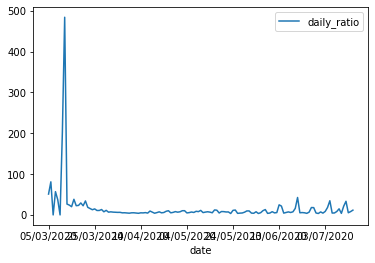

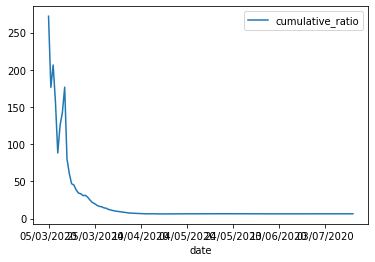

In [50]:
cases_deaths_ratio.plot(x='date',y='daily_ratio')
cases_deaths_ratio.plot(x='date',y='cumulative_ratio')

These graphs tell us 